In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,RNN,GRU
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from statsmodels.tsa.stattools import adfuller

In [3]:
df = pd.read_csv('1.csv')
print(df.dtypes)
df.head()


Timestamp [ms]                               int64
\tCPU cores                                  int64
\tCPU capacity provisioned [MHZ]           float64
\tCPU usage [MHZ]                          float64
\tCPU usage [%]                            float64
\tMemory capacity provisioned [KB]         float64
\tMemory usage [KB]                        float64
\tDisk read throughput [KB/s]              float64
\tDisk write throughput [KB/s]             float64
\tNetwork received throughput [KB/s]       float64
\tNetwork transmitted throughput [KB/s]    float64
dtype: object


,Timestamp [ms],\tCPU cores,\tCPU capacity provisioned [MHZ],\tCPU usage [MHZ],\tCPU usage [%],\tMemory capacity provisioned [KB],\tMemory usage [KB],\tDisk read throughput [KB/s],\tDisk write throughput [KB/s],\tNetwork received throughput [KB/s],\tNetwork transmitted throughput [KB/s]
0,1372629804,2,5851.9989,87.779984,1.500000,8218624.0,1.034593e+06,160.866667,21.733333,0.266667,1.466667
1,1372630104,2,5851.9989,29.259995,0.500000,8218624.0,4.585755e+05,0.000000,2.333333,0.200000,1.000000
2,1372630404,2,5851.9989,27.309328,0.466667,8218624.0,1.845480e+05,32.066667,4.200000,0.133333,1.066667
3,1372630704,2,5851.9989,23.407996,0.400000,8218624.0,7.829227e+04,0.000000,0.866667,0.066667,1.000000
4,1372631004,2,5851.9989,19.506663,0.333333,8218624.0,1.677720e+05,0.000000,0.200000,0.133333,1.000000


In [4]:
df=pd.read_csv('1.csv')

In [5]:
df['Timestamp [ms]'] = pd.to_datetime(df['Timestamp [ms]'].index,unit='s')


# df['CPU cores']=df['\tCPU cores'].replace("\t"," ", regex=True)
# df['col'].replace("\t"," ", regex=True)
# df['col'].replace("\t"," ", regex=True)
df.head(4)

,Timestamp [ms],\tCPU cores,\tCPU capacity provisioned [MHZ],\tCPU usage [MHZ],\tCPU usage [%],\tMemory capacity provisioned [KB],\tMemory usage [KB],\tDisk read throughput [KB/s],\tDisk write throughput [KB/s],\tNetwork received throughput [KB/s],\tNetwork transmitted throughput [KB/s]
0,1970-01-01 00:00:00,2,5851.9989,87.779984,1.500000,8218624.0,1.034593e+06,160.866667,21.733333,0.266667,1.466667
1,1970-01-01 00:00:01,2,5851.9989,29.259995,0.500000,8218624.0,4.585755e+05,0.000000,2.333333,0.200000,1.000000
2,1970-01-01 00:00:02,2,5851.9989,27.309328,0.466667,8218624.0,1.845480e+05,32.066667,4.200000,0.133333,1.066667
3,1970-01-01 00:00:03,2,5851.9989,23.407996,0.400000,8218624.0,7.829227e+04,0.000000,0.866667,0.066667,1.000000


In [6]:
df.dtypes

Timestamp [ms]                             datetime64[ns]
\tCPU cores                                         int64
\tCPU capacity provisioned [MHZ]                  float64
\tCPU usage [MHZ]                                 float64
\tCPU usage [%]                                   float64
\tMemory capacity provisioned [KB]                float64
\tMemory usage [KB]                               float64
\tDisk read throughput [KB/s]                     float64
\tDisk write throughput [KB/s]                    float64
\tNetwork received throughput [KB/s]              float64
\tNetwork transmitted throughput [KB/s]           float64
dtype: object

In [7]:
type(df.index)
print(df.shape)

(8260, 11)


In [8]:
df.columns

Index(['Timestamp [ms]', '\tCPU cores', '\tCPU capacity provisioned [MHZ]',
       '\tCPU usage [MHZ]', '\tCPU usage [%]',
       '\tMemory capacity provisioned [KB]', '\tMemory usage [KB]',
       '\tDisk read throughput [KB/s]', '\tDisk write throughput [KB/s]',
       '\tNetwork received throughput [KB/s]',
       '\tNetwork transmitted throughput [KB/s]'],
      dtype='object')

In [9]:
df=df.iloc[:,[0,3]]

df.columns=['time','cpu_usage']
print(df.head(10))

                 time  cpu_usage
0 1970-01-01 00:00:00  87.779984
1 1970-01-01 00:00:01  29.259995
2 1970-01-01 00:00:02  27.309328
3 1970-01-01 00:00:03  23.407996
4 1970-01-01 00:00:04  19.506663
5 1970-01-01 00:00:05  29.259995
6 1970-01-01 00:00:06  29.259995
7 1970-01-01 00:00:07  29.259995
8 1970-01-01 00:00:08  29.259995
9 1970-01-01 00:00:09  19.506663


<h2>Applying GRU model on the  train set</h2> 


In [10]:

dataset = df.cpu_usage.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))



scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))


In [11]:
model = Sequential()
model.add(GRU(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

Epoch 1/20
94/94 [==============================] - 2s 9ms/step - loss: 0.0045 - val_loss: 0.0015
Epoch 2/20
94/94 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 4.9479e-04
Epoch 3/20
94/94 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 7.1615e-04
Epoch 4/20
94/94 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 6.8906e-04
Epoch 5/20
94/94 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 5.8764e-04
Epoch 6/20
94/94 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 5.8764e-04
Epoch 7/20
94/94 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 6.3521e-04
Epoch 8/20
94/94 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 7.5123e-04
Epoch 9/20
94/94 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 5.6256e-04
Epoch 10/20
94/94 [==============================] - 0s 3ms/step - loss: 0.0019 - val_

In [12]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])


print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 76.20402954907573
Train Root Mean Squared Error: 124.6054332800802
Test Mean Absolute Error: 62.2623529251718
Test Root Mean Squared Error: 92.1670241524423


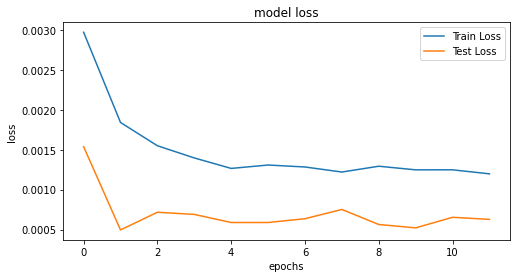

In [13]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [14]:
print(train_size,test_size)
df.time[train_size:]

6608 1652


6608   1970-01-01 01:50:08
6609   1970-01-01 01:50:09
6610   1970-01-01 01:50:10
6611   1970-01-01 01:50:11
6612   1970-01-01 01:50:12
               ...        
8255   1970-01-01 02:17:35
8256   1970-01-01 02:17:36
8257   1970-01-01 02:17:37
8258   1970-01-01 02:17:38
8259   1970-01-01 02:17:39
Name: time, Length: 1652, dtype: datetime64[ns]

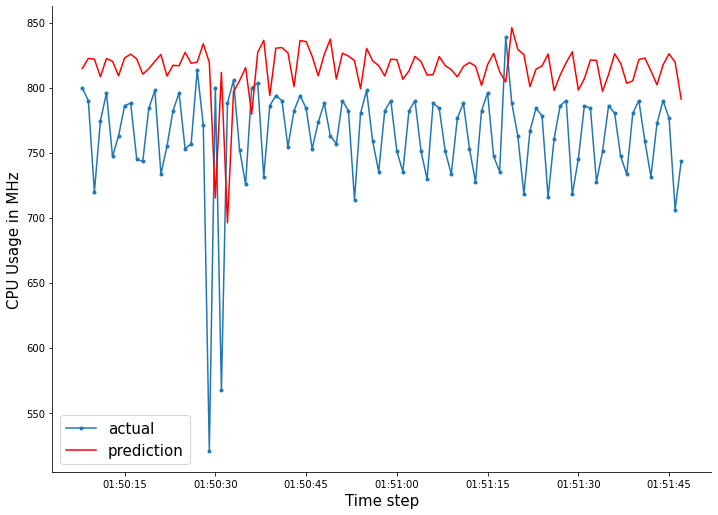

In [15]:
aa=df.time[train_size:][:100]
plt.figure(figsize=(10,7))
plt.plot(aa, Y_test[0][:100], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:100], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('CPU Usage in MHz', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();